In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import torch
import torch.nn as nn
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from pyret.filtertools import decompose
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
import fnn.models as models
from fnn.evaluation import *
from fnn.distributions import *
from fnn.notebook.utils import *
from fnn.notebook.utils_discrim import *

In [3]:
file_path = '/home/xhding/tem_stim/16-05-31/naturalscene_test.h5'
cells = list(range(8))
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
recording = recording_stats(file_path, cells)
single_trial_bin = recording.single_trial_bin

In [4]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('fc_phase2_16-05-31')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_050_loss_-33.40_pearson_0.9593.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 8, device)

w = model.ganglion[-1].w.data.cpu().numpy()
w = w.reshape(8, 18, 18)
true_idxs = np.where(w == 1)

b = model.ganglion[3].bias.data.reshape((8,18,18))
b_true = b[true_idxs[0], true_idxs[1], true_idxs[2]]
b = torch.zeros_like(b) + b_true[:,None,None]
model.ganglion[3].bias.data = b.flatten()

w = model.ganglion[3].weight.data.reshape((8,18,18))
w_true = w[true_idxs[0], true_idxs[1], true_idxs[2]]
w = torch.zeros_like(w) + w_true[:,None,None]
model.ganglion[3].weight.data = w.flatten()

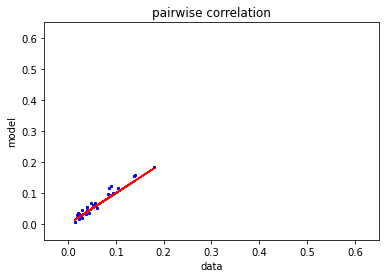

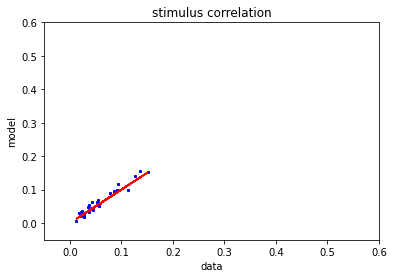

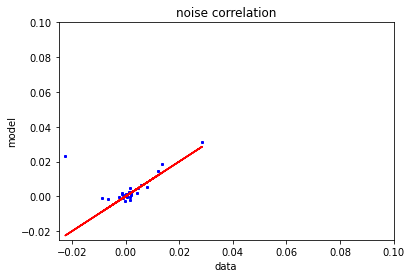

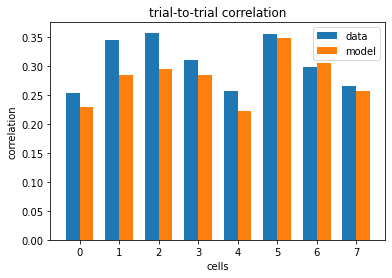

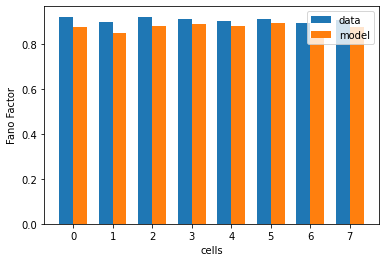

0.0003976550048060059


In [6]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=21, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=21, thre=2)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [39, 60])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [8]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(96593.0, 96910)

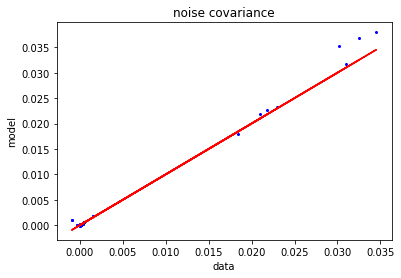

In [7]:
covariance_plot(single_trial_bin, pred_single_trial_try)

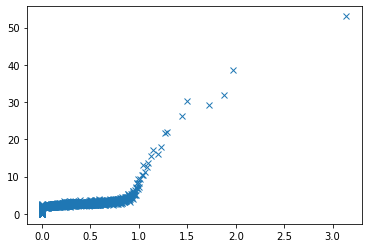

In [86]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=21, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)

time = 1527
x = TestDataset(cfg)[time:time+1][0].to(device)

w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
norm_grads = compute_grad_norm(model, x, device, v)

plt.plot(np.sqrt(w), norm_grads, 'x')

In [20]:
pred[1527]

array([ 6.842977 , 18.853273 , 21.320797 , 13.846573 , 10.46954  ,
       36.56101  ,  5.3160777, 14.781659 ], dtype=float32)

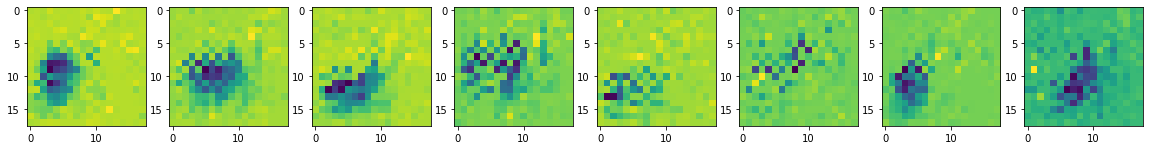

In [23]:
fig, axs = plt.subplots(1, 8, figsize=(20, 3))
for cell in range(8):
    axs[cell].imshow(v[:, -1].reshape((8, 18, 18))[cell])
plt.show()

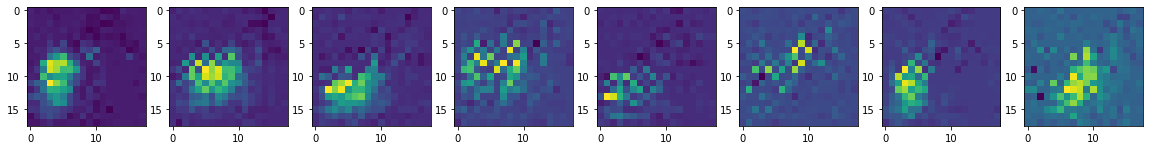

In [13]:
fig, axs = plt.subplots(1, 8, figsize=(20, 3))
for cell in range(8):
    axs[cell].imshow(v[:, -1].reshape((8, 18, 18))[cell])
plt.show()

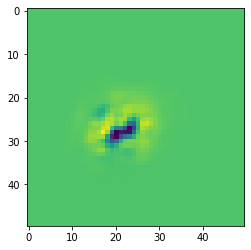

In [15]:
idx = -1
mode_vec = v[:, idx]
sta = mode_inst_RF(model, x, device, mode_vec)
s, t = decompose(sta)
plt.imshow(s)
plt.show()

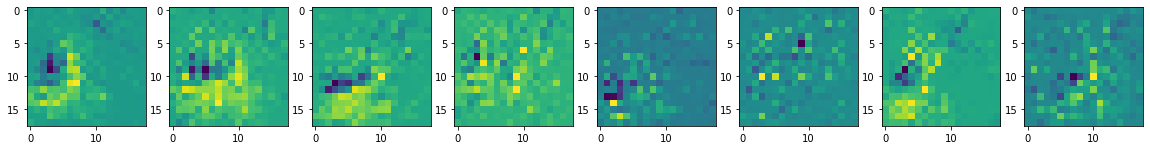

In [27]:
fig, axs = plt.subplots(1, 8, figsize=(20, 3))
for cell in range(8):
    axs[cell].imshow(v[:, -4].reshape((8, 18, 18))[cell])
plt.show()

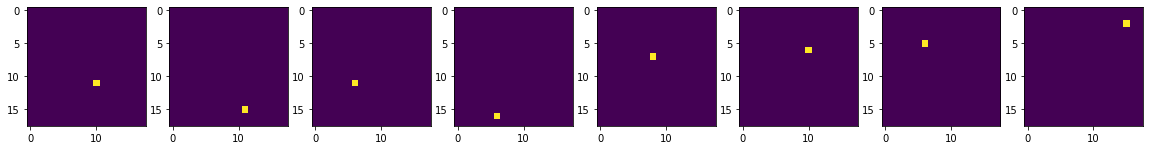

In [33]:
onehot_w = model.ganglion[-1].w.data.cpu().numpy().reshape((8,18,18))
fig, axs = plt.subplots(1, 8, figsize=(20, 3))
for cell in range(8):
    axs[cell].imshow(onehot_w[cell])
plt.show()

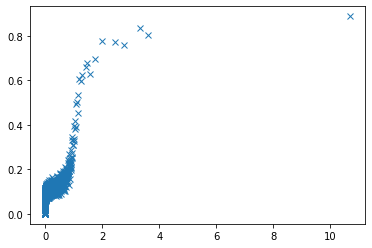

In [48]:
time = 1527
x = TestDataset(cfg)[time:time+1][0].to(device)

w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
cos = cosines(model, x, device, v)
plt.plot(w, cos, 'x')

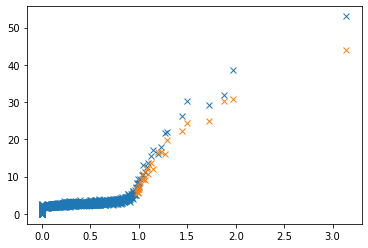

In [99]:
plt.plot(np.sqrt(w), norm_grads, 'x')
plt.plot(np.sqrt(w)[-25:], pure_grads, 'x')
plt.show()

In [163]:
coses_all = []
for time in range(len(TestDataset(cfg))):
    if pred.mean(1)[time] > 8:
        x = TestDataset(cfg)[time:time+1][0].to(device)
        w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
        grads = compute_grads(model, x, device, v)
        coses = coses_grads(grads, top_num=10)
        coses_all.append(coses)
coses_10 = np.array(coses_all)

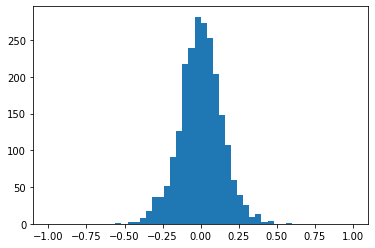

In [164]:
#plt.hist(coses_15.flatten(), range=(-1,1), bins=50)
plt.hist(coses_10.flatten(), range=(-1,1), bins=50)
plt.show()

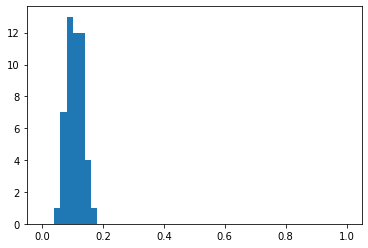

In [169]:
plt.hist(np.abs(coses_10).mean(1), range=(0,1), bins=50)
plt.show()

In [5]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=21, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)

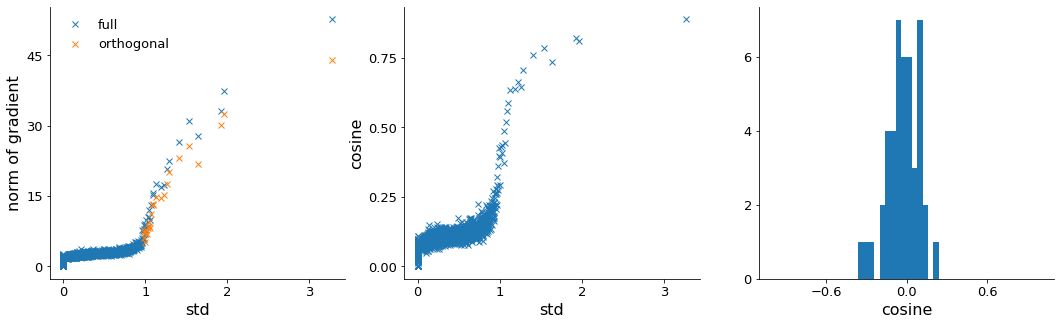

In [12]:
time = 1527
x = TestDataset(cfg)[time:time+1][0].to(device)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
cos = cosines(model, x, device, v)
ax[1].plot(np.sqrt(w), cos, 'x')
ax[1].set_xlabel('std', fontsize=16)
ax[1].set_ylabel('cosine', fontsize=16)

grads = compute_grads(model, x, device, v)
norm_grads = np.linalg.norm(grads.reshape(grads.shape[0], -1), ord=2, axis=1)
pure_grads = ortho_component_norm(grads, top_num=25)
ax[0].plot(np.sqrt(w), norm_grads, 'x', label='full')
ax[0].plot(np.sqrt(w)[-25:], pure_grads, 'x', label='orthogonal')
ax[0].set_xlabel('std', fontsize=16)
ax[0].set_ylabel('norm of gradient', fontsize=16)
ax[0].legend(fontsize=13, frameon=False)

coses = coses_grads(grads, top_num=10)
ax[2].hist(coses, range=(-1,1), bins=50)
ax[2].set_xlabel('cosine', fontsize=16)

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].tick_params(axis='both', which='major', labelsize=13)

plt.show()

Text(0, 0.5, 'Fisher information')

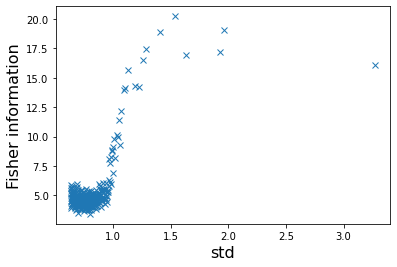

In [20]:
idx = -300
plt.plot(np.sqrt(w)[idx:], norm_grads[idx:]/np.sqrt(w)[idx:], 'x')
plt.xlabel('std', fontsize=16)
plt.ylabel('Fisher information', fontsize=16)

In [133]:
np.where(pred.mean(1)>8)

(array([ 208,  209,  210,  211,  325,  326,  327,  328,  329, 1526, 1527,
        1528, 1529, 1530, 1534, 1535, 1646, 1647, 1648, 2070, 2071, 2072,
        2073, 2125, 2126, 2127, 2128, 2129, 2252, 2253, 2254, 2255, 2256,
        2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2486, 2487,
        2488, 2489, 2846, 2847, 2848, 2849]),)

In [171]:
p_modes = []
for time in range(len(TestDataset(cfg))):
    if pred.mean(1)[time] > 8:
        x = TestDataset(cfg)[time:time+1][0].to(device)
        w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
        p_modes.append(v[:, -1])
p_modes = np.array(p_modes)
p_modes /= np.expand_dims(np.linalg.norm(p_modes, ord=2, axis=1), -1)

coses = []
for i in range(p_modes.shape[0]):
    for j in range(i+1, p_modes.shape[0]):
        coses.append(p_modes[i].dot(p_modes[j]))

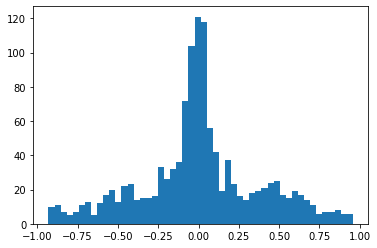

In [179]:
plt.hist(coses, bins=50)
plt.show()

In [6]:
time = 1527
x = TestDataset(cfg)[time:time+1][0].to(device)
w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
grads = compute_grads(model, x, device, v)

In [7]:
grads.shape

(2592, 40, 50, 50)

In [9]:
top_num = 25

num_modes = grads.shape[0]
grad_mat = np.swapaxes(grads.reshape(num_modes, -1), 0, 1)
grad_mat_top = grad_mat[:, -top_num:]
q = np.linalg.qr(grad_mat_top)[0]

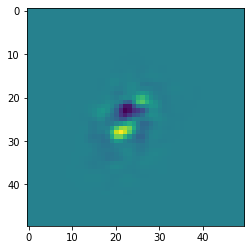

In [42]:
a = grads.reshape(num_modes, -1).dot(q)
b = np.expand_dims(a, axis=1) * np.expand_dims(a, axis=2)
top = 500
fisher = (b[-top:] / np.expand_dims(w[-top:], axis=(1,2))).sum(0)
max_stim = q.dot(np.linalg.eigh(fisher)[1][:, -1]).reshape(40,50,50)
s, t = decompose(max_stim)
plt.imshow(s)
plt.show()